# Statistical Comparisons Generator

This notebook separates different measurement categories into numerous populations and compares the statistical significance of data trends

In [2]:
#all package imports needed for notebook here
import pandas as pd

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import seaborn as sns
import numpy as np
import pprint as pp
from datetime import datetime
from IPython.display import display

df2013 = pd.read_csv('Kwadella_winter_2013_cleaned.csv')
df2014 = pd.read_csv('Kwadella_winter_2014_cleaned.csv')

/home/mackenzie/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/mackenzie/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


First we're looking at an analysis of variance between 2014 and 2013 to see how significantly the years differed. We'll look at how the outdoor temperatures varied (as a soft control), then compare the year's pollutant concentrations  to get a read for how well the intervention reduced pollution. We'll do this again with diurnal plots to be sure. 

Cross correlation will let us track dusttraks vs PM2.5 vs PM10 vs CO concentrations and traking the rise and fall of each pollutant over the course of the entire winter. We're starting by just looking at the entire winter, then we may divide pollution measurements based on temperature deviation of a given day or by month

Kruskal is best for comparing one category of measurement at different time points to see if there is significant variance between those groups. for example:  Krusal done on dusttraks from the mean temp track, dusttraks from 1 sd colder than the mean, and dusttraks from 1 sd warmer than the mean. This measurement would tell us if there is variance in pollution between the three groups. This test could also be applied to 2013 vs 2014 dusttraks to find statistical significance in the differences in pollution before and after intervention

In [3]:
def get_datetime(s):
    """strips date and time from the already existing date column"""
    dt = datetime.strptime(s, "%m/%d/%y %H:%M")
    return dt

def daysSinceStart(df):
    """get time since epoch using a series for month and day
    takes in dataframe and returns the dataframe with an added colum for days since the beginning of data collection"""
    dayArray = np.array(df.Day)
    monthArray = np.array(df.Month)
    
    runningDays = []
    for day, month in zip(dayArray, monthArray):
        if month == 7:
            total_days = 0
        elif month == 8:
            total_days = 31 
        elif month == 9:
            total_days = 61
        else:
            raise ValueError 
        total_days = total_days + day
        runningDays.append(total_days)
    df['DayCount'] = pd.Series(runningDays, index = df.index)
    return df

#Daily Average Outdoor Temp
def compute_avg_temp(df):
    df['DailyAverageTemp'] = df['Temperature_(degC)'].mean()
    return df

#each minute's avg indoor temp
def compute_avg_house13(df):
    """tailored to compute the average indoor house temperature of 2013"""
    df['AvgHouse'] = (df['H01-K-E']+ df['H02-K-N']+ df['H03-K-S']+ df['H04-K-S']
                      + df['H05-K-N']+df['H06-K-N'] + df['H10-K-N']
                      +df['H11-K-X']+ df['H12-K-N'] + df['H15-K-S'] +df['H17-K-N'] 
                      + df['H18-K-S'] + df['H20-K-S']
                      )/13
    return df

def compute_avg_house14(df):
    """tailored to compute the avg indoor house temp for 2014"""
    df['AvgHouse'] = (df['H01-K-E']+ df['H02-K-N']+ df['H03-K-S']+ df['H04-K-S']
                      + df['H05-K-N']+df['H06-K-N'] + df['H10-K-N']
                      +df['H11-K-N'] + df['H15-K-N']+df['H16-K-N'] +df['H17-K-S'] 
                      + df['H18-K-N']+df['H19-K-W'] + df['H22-K-S']
                      )/14
    return df

def preprocess(df):
    """runs the datetime and daysSinceStart helper functions
    takes and returns a dataframe"""
    res = df.copy()
    datetimes = res.Date.apply(get_datetime)
    res['Hour'] = datetimes.apply(lambda dt: dt.hour)
    res['Day'] = datetimes.apply(lambda dt: dt.day)
    res['Month'] = datetimes.apply(lambda dt: dt.month)
    res['Year'] = datetimes.apply(lambda dt: dt.year)
    return res

In [32]:
df2013 = preprocess(df2013)
df2013 = daysSinceStart(df2013)
grouped = df2013.groupby('DayCount')
df2013 = grouped.apply(compute_avg_temp)
df2013 = compute_avg_house13(df2013)
df2013['Dusttraks_(mg/m3)']= df2013['Dusttraks_(mg/m3)']*0.14


df2014 = daysSinceStart(df2014)
grouped = df2014.groupby('DayCount')
df2014 = grouped.apply(compute_avg_temp)
df2014 = compute_avg_house14(df2014)
df2014['Dusttraks_(mg/m3)']= df2014['Dusttraks_(mg/m3)']*0.14

In [33]:
df2013.DailyAverageTemp

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20       NaN
21       NaN
22       NaN
23       NaN
24       NaN
25       NaN
26       NaN
27       NaN
28       NaN
29       NaN
          ..
125325   NaN
125326   NaN
125327   NaN
125328   NaN
125329   NaN
125330   NaN
125331   NaN
125332   NaN
125333   NaN
125334   NaN
125335   NaN
125336   NaN
125337   NaN
125338   NaN
125339   NaN
125340   NaN
125341   NaN
125342   NaN
125343   NaN
125344   NaN
125345   NaN
125346   NaN
125347   NaN
125348   NaN
125349   NaN
125350   NaN
125351   NaN
125352   NaN
125353   NaN
125354   NaN
Name: DailyAverageTemp, dtype: float64

 the normalize function literally normalizes a dataframe, you just have to be careful you give it only columns with integers that you want to normalize together(ie don't give it DayCounts or another time/date indicator). 

A large chunk of our data is nan, to the point where it's actually a bad idea to drop nans and filling any in won't give us meaningful data.We found out that pandas actually does a pretty good job just ignoring nans when performing operations, so we actually stayed away from using numpy and scipy for all the following operations, and stuck to pandas methods.

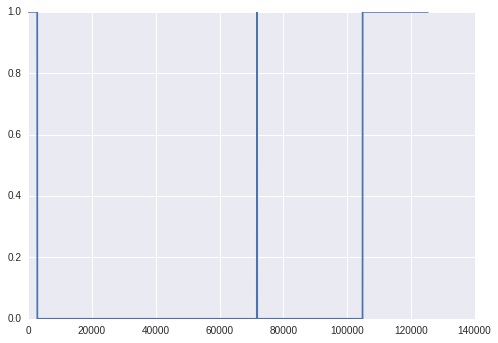

In [6]:
def normalize(df, headers):
    """Normalizes values of a dataframe after filling missing values- see FillMissing
    df: dataframe of un-normalized integer only data
    headers: specifc columns to be compared to one another
    returns: now normalized dataframe of only the specified headers with missing values filled in"""
    normdf = df[headers]
    df_norm = (normdf-normdf.mean())/(normdf.max() - normdf.min())
    return df_norm

intHeadCorrList= [ 'Temperature_(degC)','Dusttraks_(mg/m3)', 'PM10_(ug/m3)','PM2.5_(ug/m3)','SO2_(ppb)','CO_(ppm)','NO_(ppb)',
                 'NO2_(ppb)','AvgHouse']
plt.plot(df2013[intHeadCorrList[0:1]].isnull().mean(axis=1))
dfnorm13 = normalize(df2013, intHeadCorrList)

We chose a spearman correlation because it doesn't rely on the parameters a perason's correlation does. The pandas methof dataframe.corr let us pick spearman, ignores nans (a must have) and constructs a useful dataframe of correlation coefficients that just make the whole matrix process a lot less painful.

In [7]:
speardf = dfnorm13.corr(method = 'spearman')
print speardf.head()

                    Temperature_(degC)  Dusttraks_(mg/m3)  PM10_(ug/m3)  \
Temperature_(degC)            1.000000           0.025234      0.320008   
Dusttraks_(mg/m3)             0.025234           1.000000      0.388485   
PM10_(ug/m3)                  0.320008           0.388485      1.000000   
PM2.5_(ug/m3)                 0.012230           0.349414      0.353744   
SO2_(ppb)                     0.375853           0.280002      0.455247   

                    PM2.5_(ug/m3)  SO2_(ppb)  CO_(ppm)  NO_(ppb)  NO2_(ppb)  \
Temperature_(degC)       0.012230   0.375853 -0.252044  0.083755   0.172606   
Dusttraks_(mg/m3)        0.349414   0.280002  0.137353  0.389796   0.278899   
PM10_(ug/m3)             0.353744   0.455247  0.217672  0.268485   0.454548   
PM2.5_(ug/m3)            1.000000   0.162776  0.310283  0.146666   0.291135   
SO2_(ppb)                0.162776   1.000000  0.282189  0.517021   0.717334   

                    AvgHouse  
Temperature_(degC)  0.770790  
Dusttraks_(m

In [8]:
def correlationHeatmap(corrmat, year = ''):
    """Constructs a heatmap correlation matrix
    corrmat: dataframe of correlation constants
    year: year to which data applies"""
#set up mask to cover upper triangle of the matrix 
    mask = np.zeros_like(speardf, dtype=np.bool)
    mask[np.triu_indices_from(mask, k=1)] = True

# Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
    sns.heatmap(corrmat,mask=mask, vmax=.8, square=True)

    plt.title('Winter of '+ year+ ' Temperature and Pollutant Correlations')
    plt.xticks(rotation=30)
    f.tight_layout()

This code for a cross correlation heatmap taken from some helpful seaborn documentation from stanford: https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.heatmap.html

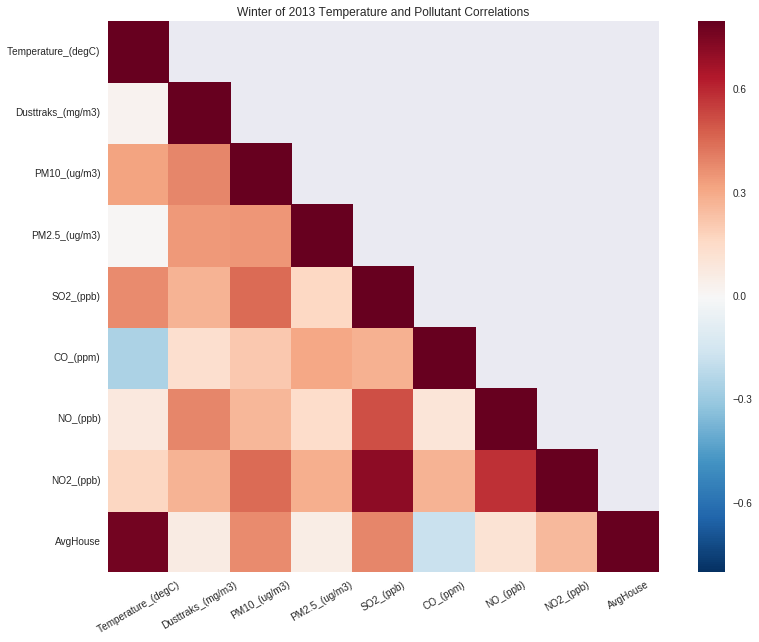

In [9]:
correlationHeatmap(speardf, '2013')

Do this with 2014, cold, warm, hot, and diurnal profiles

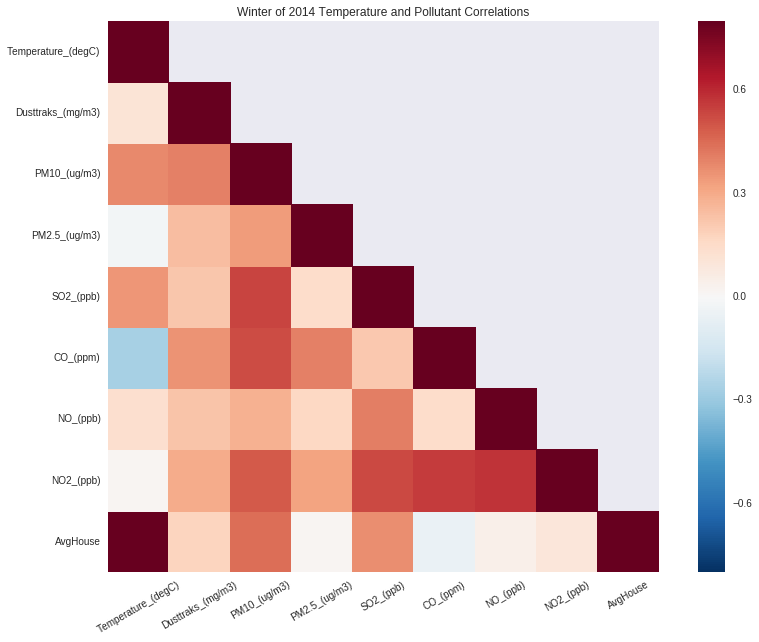

In [10]:
dfnorm14 = normalize(df2014, intHeadCorrList)
speardf14 = dfnorm14.corr(method = 'spearman')
correlationHeatmap(speardf14, '2014')

Now I'm trying to look at the difference between quartiles

In [25]:

#GENERAL FUNCTION FOR DIURNAL DATA

def getmeanfeatureforhour (hourdf, feature):
    res = hourdf[feature].mean()
    return res
def featurediurnaldata(df, feature):
    #feature for example could be a temperature or pollutant concentration
    dfhour0 = df[df['Hour'] == 0]
    feat0 = getmeanfeatureforhour(dfhour0, feature)
    dfhour1 = df[df['Hour'] == 1]
    feat1= getmeanfeatureforhour(dfhour1, feature)
    dfhour2 = df[df['Hour'] == 2]
    feat2 = getmeanfeatureforhour(dfhour2, feature)
    dfhour3 = df[df['Hour'] == 3]
    feat3 = getmeanfeatureforhour(dfhour3, feature)
    dfhour4 = df[df['Hour'] == 4]
    feat4 = getmeanfeatureforhour(dfhour4, feature)
    dfhour5 = df[df['Hour'] == 5]
    feat5 = getmeanfeatureforhour(dfhour5, feature)
    dfhour6 = df[df['Hour'] == 6]
    feat6 = getmeanfeatureforhour(dfhour6, feature)
    dfhour7 = df[df['Hour'] == 7]
    feat7 = getmeanfeatureforhour(dfhour7, feature)
    dfhour8 = df[df['Hour'] == 8]
    feat8 = getmeanfeatureforhour(dfhour8, feature)
    dfhour9 = df[df['Hour'] == 9]
    feat9 = getmeanfeatureforhour(dfhour9, feature)
    dfhour10 = df[df['Hour'] == 10]
    feat10 = getmeanfeatureforhour(dfhour10, feature)
    dfhour11 = df[df['Hour'] == 11]
    feat11 = getmeanfeatureforhour(dfhour11, feature)
    dfhour12 = df[df['Hour'] == 12]
    feat12 = getmeanfeatureforhour(dfhour12, feature)
    dfhour13 = df[df['Hour'] == 13]
    feat13 = getmeanfeatureforhour(dfhour13, feature)
    dfhour14 = df[df['Hour'] == 14]
    feat14 = getmeanfeatureforhour(dfhour14, feature)
    dfhour15 = df[df['Hour'] == 15]
    feat15 = getmeanfeatureforhour(dfhour15, feature)
    dfhour16 = df[df['Hour'] == 16]
    feat16 = getmeanfeatureforhour(dfhour16, feature)
    dfhour17 = df[df['Hour'] == 17]
    feat17 = getmeanfeatureforhour(dfhour17, feature)
    dfhour18 = df[df['Hour'] == 18]
    feat18 = getmeanfeatureforhour(dfhour18, feature)
    dfhour19 = df[df['Hour'] == 19]
    feat19 = getmeanfeatureforhour(dfhour19, feature)
    dfhour20 = df[df['Hour'] == 20]
    feat20 = getmeanfeatureforhour(dfhour20, feature)
    dfhour21 = df[df['Hour'] == 21]
    feat21 = getmeanfeatureforhour(dfhour21, feature)
    dfhour22 = df[df['Hour'] == 22]
    feat22 = getmeanfeatureforhour(dfhour22, feature)
    dfhour23 = df[df['Hour'] == 23]
    feat23 = getmeanfeatureforhour(dfhour23, feature)

    hourlist = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    featlist = [feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,feat15,feat16,feat17,feat18,feat19,feat20,feat21,feat22,feat23]
    return featlist

def quartileGenerator(df):
    
    warmcutoff = 14.4
    coldcutoff = 8.7

    dfcold = df[df['DailyAverageTemp'] <= coldcutoff]
    print dfcold.head()
    dfmid = df[df['DailyAverageTemp'] > coldcutoff]
    dfmid = dfmid[dfmid['DailyAverageTemp'] < warmcutoff]
    dfwarm = df[df['DailyAverageTemp'] >= warmcutoff]

    tempdiurnalcold = featurediurnaldata(dfcold, 'DailyAverageTemp')
    
    return dfcold,dfmid,dfwarm,tempdiurnalcold 

In [37]:
dfcold13,dfmid13,dfwarm13,tempdirunalcold13 = quartileGenerator(df2013)

       Unnamed: 0  Dusttraks_(mg/m3)  PM10_(ug/m3)  PM2.5_(ug/m3)  SO2_(ppb)  \
10680       10800           0.002117        84.649         28.664     14.646   
10681       10801           0.002117        80.349         59.613     12.451   
10682       10802           0.002097        80.349         59.613     12.451   
10683       10803           0.002097        80.349         59.613     12.451   
10684       10804           0.002097        80.349         59.613     12.451   

       CO_(ppm)  NO_(ppb)  NO2_(ppb)          Date  Temperature_(degC)  \
10680    -0.086     1.030      4.255  7/10/13 0:00               6.090   
10681    -0.134     1.299      3.986  7/10/13 0:01               6.068   
10682    -0.134     1.299      3.986  7/10/13 0:02               6.068   
10683    -0.134     1.299      3.986  7/10/13 0:03               6.068   
10684    -0.134     1.299      3.986  7/10/13 0:04               6.068   

         ...     H17-K-N  H18-K-S  H20-K-S  Hour  Day  Month  Year  DayCou

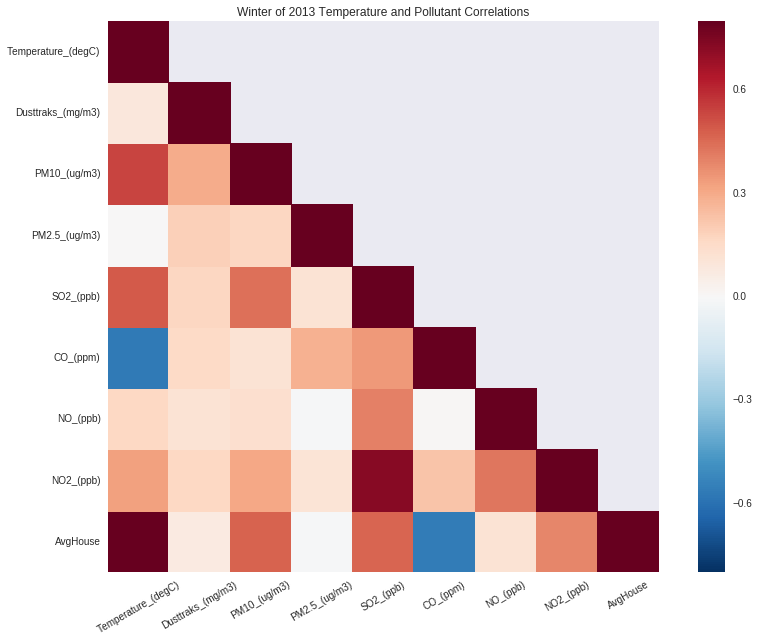

In [40]:
dfnormwarm13 = normalize(dfwarm13, intHeadCorrList)
speardfwarm13 = dfnormwarm13.corr(method = 'spearman')
correlationHeatmap(speardfwarm13, '2013')

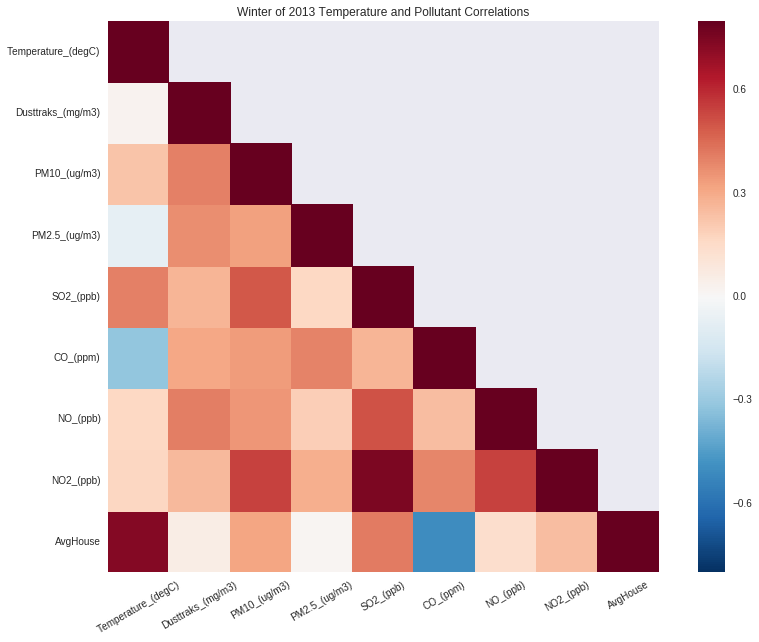

In [41]:
dfnormmid13 = normalize(dfmid13, intHeadCorrList)
speardfmid13 = dfnormmid13.corr(method = 'spearman')
correlationHeatmap(speardfmid13, '2013')

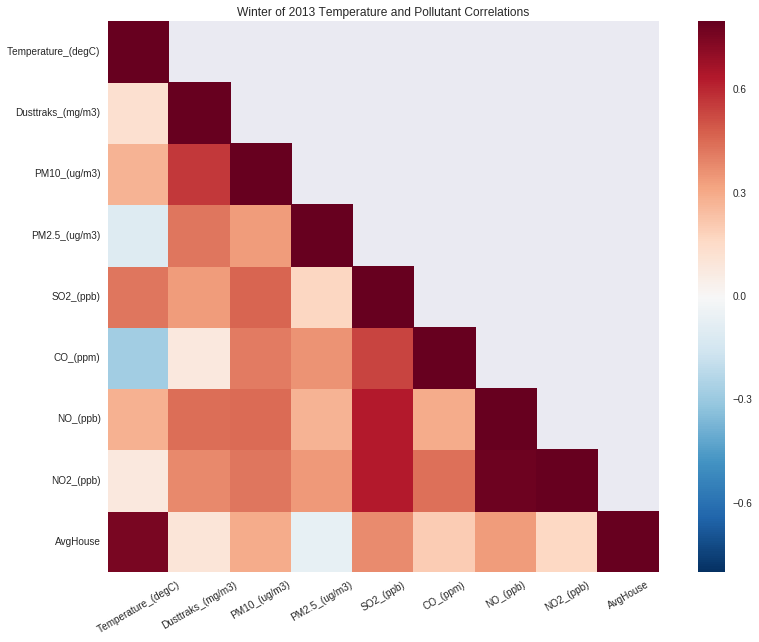

In [42]:
dfnormcold13 = normalize(dfcold13, intHeadCorrList)
speardfcold13 = dfnormcold13.corr(method = 'spearman')
correlationHeatmap(speardfcold13, '2013')

In [44]:
dfcold14,dfmid14,dfwarm14,tempdirunalcold14 = quartileGenerator(df2014)

   Unnamed: 0  Dusttraks_(mg/m3)  PM10_(ug/m3)  PM2.5_(ug/m3)  SO2_(ppb)  \
0           0           0.000843           NaN         31.576        NaN   
1           1           0.000804           NaN         32.248        NaN   
2           2           0.000823           NaN         12.765        NaN   
3           3           0.000862           NaN          2.687        NaN   
4           4           0.000843           NaN          3.807        NaN   

   CO_(ppm)  NO_(ppb)  NO2_(ppb)  Hour  Minute    ...      H11-K-N  H15-K-N  \
0     0.193     6.494      8.734    12       0    ...         16.2     15.3   
1     0.163     5.375      8.286    12       1    ...         16.5     15.4   
2     0.188     5.375      8.062    12       2    ...         16.8     15.5   
3     0.206     5.375      8.062    12       3    ...         17.0     15.5   
4     0.240     4.927      8.062    12       4    ...         17.2     15.5   

   H16-K-N  H17-K-S  H18-K-N  H19-K-W  H22-K-S  DayCount  DailyAvera

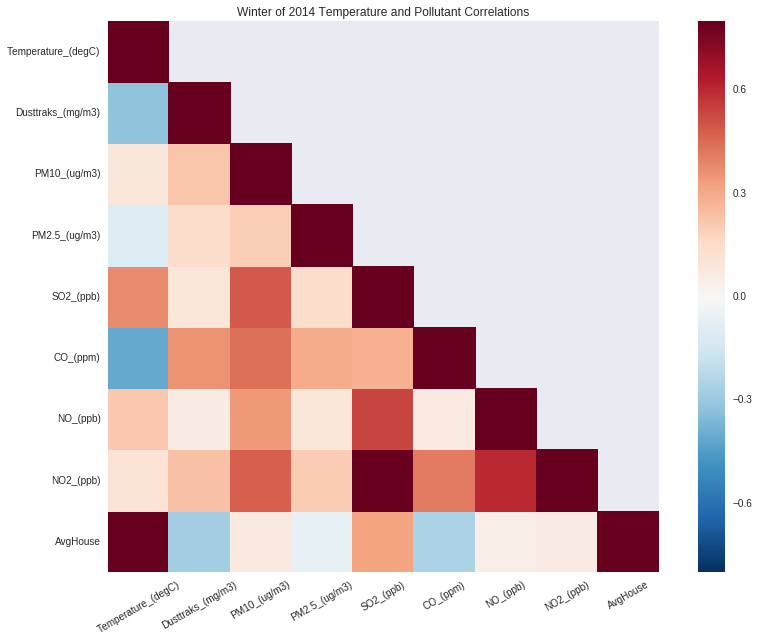

In [45]:
dfnormwarm14 = normalize(dfwarm14, intHeadCorrList)
speardfwarm14 = dfnormwarm14.corr(method = 'spearman')
correlationHeatmap(speardfwarm14, '2014')

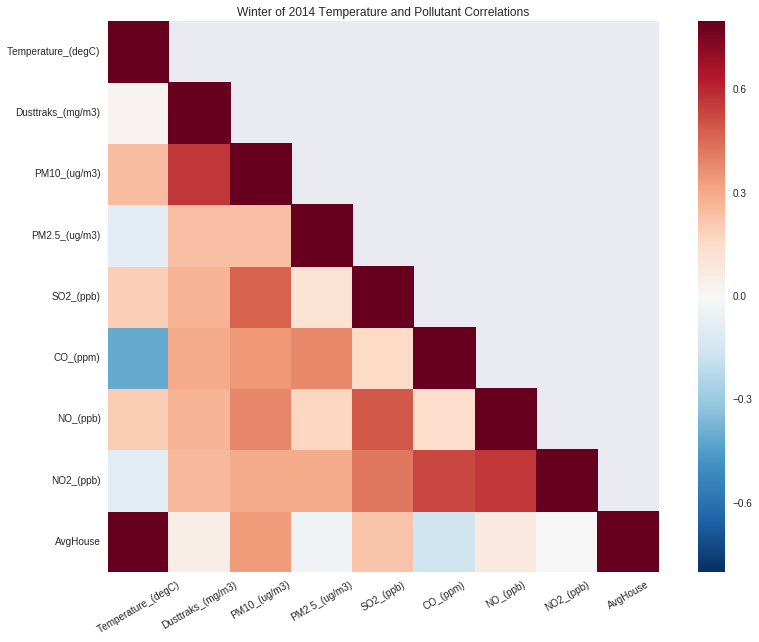

In [46]:
dfnormmid14 = normalize(dfmid14, intHeadCorrList)
speardfmid14 = dfnormmid14.corr(method = 'spearman')
correlationHeatmap(speardfmid14, '2014')

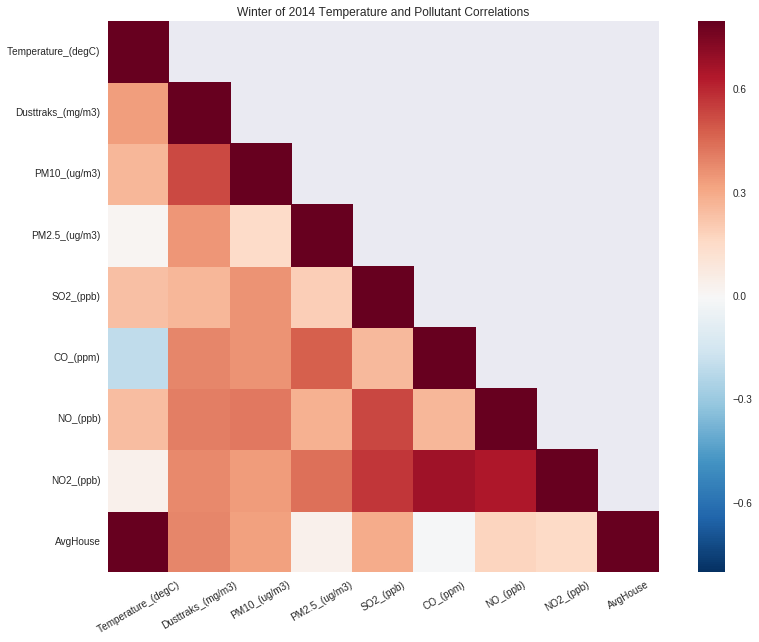

In [47]:
dfnormcold14 = normalize(dfcold14, intHeadCorrList)
speardfcold14 = dfnormcold14.corr(method = 'spearman')
correlationHeatmap(speardfcold14, '2014')